In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from glob import glob
import random
import jsonlines
from torch.utils.data import Dataset
from util import *
import torch
from tqdm import tqdm
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from sklearn.manifold import TSNE
import hdbscan
from sklearn.cluster import KMeans
import plotly.express as px
import pandas as pd

from dataset import JointRelatedWorkAnnotationDataset, CORWAanalysisDataset

In [3]:
discourse_label_types = {
    "Transition":0,
    "Single_summ": 1,
    "Multi_summ": 2,
    "Narrative_cite":3,
    "Reflection":4,
    "Other":5
    }

special_tokens = ['[BOS]', '[B_span]', '[E_span]', '[B_Dominant]', '[I_Dominant]', '[E_Dominant]', '[B_Reference]', '[I_Reference]','[E_Reference]', '[O]']
discourse_tokens = []
for k,v in discourse_label_types.items():
    discourse_tokens.append("["+k+"]")
special_tokens.extend(discourse_tokens)

tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
additional_special_tokens = {'additional_special_tokens': special_tokens} 
tokenizer.add_special_tokens(additional_special_tokens)

16

In [4]:
def print_percentage(d, prior=1):
    for k, v in sorted(d.items(), key=lambda item: item[1])[::-1]:
        print(k,"{:.1%}".format(v * prior))

In [5]:
datafile = "/home/data/XiangciLi/CORWA/annotated"
dataset = JointRelatedWorkAnnotationDataset(datafile, tokenizer, MAX_SENT_LEN = 9999)

In [6]:
discourse_labels = Counter()
for data in dataset:
    discourse_labels.update(data['discourse_label'])

In [7]:
total = sum([cnt for key, cnt in discourse_labels.items()])
discourse_labels_fraction = {dataset.discourse_label_lookup[int(key)]: cnt/total for key, cnt in discourse_labels.items()}
print_percentage(discourse_labels_fraction)

Single_summ 30.7%
Transition 24.5%
Narrative_cite 18.3%
Reflection 18.0%
Multi_summ 4.9%
Other 3.6%


In [8]:
discourse_labels_fraction = {dataset.discourse_label_lookup[int(key)]: cnt for key, cnt in discourse_labels.items()}
for k, v in sorted(discourse_labels_fraction.items(), key=lambda item: item[1])[::-1]:
    print(k,v)

Single_summ 4388
Transition 3495
Narrative_cite 2622
Reflection 2576
Multi_summ 698
Other 513


In [9]:
def span_length_by_citation(dataset):
    dominant_span_lens = []
    reference_span_lens = []
    dominant_span_lens_no_citation_mark = []
    reference_span_lens_no_citation_mark = []
    
    for data in dataset:
        span_citation_mapping = data["span_citation_mapping"]
        for span in span_citation_mapping:
            if span["span_type"] == "Dominant":
                dominant_span_lens.append(span["token_end"] - span["token_start"])
                citation_mark_lens = 0
                for k,v in span["span_citation_mapping"]["Dominant"].items():
                    citation_mark_lens += len(tokenizer.tokenize(k))
                dominant_span_lens_no_citation_mark.append(span["token_end"] - span["token_start"] - citation_mark_lens)
            else:
                reference_span_lens.append(span["token_end"] - span["token_start"])
                citation_mark_lens = 0
                for k,v in span["span_citation_mapping"]["Reference"].items():
                    citation_mark_lens += len(tokenizer.tokenize(k))
                reference_span_lens_no_citation_mark.append(span["token_end"] - span["token_start"] - citation_mark_lens)

    return dominant_span_lens, dominant_span_lens_no_citation_mark, reference_span_lens, reference_span_lens_no_citation_mark

In [10]:
dataset = CORWAanalysisDataset(datafile, tokenizer)

In [12]:
dominant_span_len_ratio = []
reference_span_len_ratio = []
for data in dataset:
    for span_idx, sentence_indices in enumerate(data["span2sent_mapping"]):
        mean_sent_len = sum([len(tokenizer.tokenize(data["sentences"][sent_idx])) for sent_idx in sentence_indices]) / len(sentence_indices)
        span = data["span_citation_mapping"][span_idx]
        span_len = span["token_end"] - span["token_start"]
        ratio = span_len / mean_sent_len
        if span["span_type"] == "Dominant":
            dominant_span_len_ratio.append(ratio)
        else:
            reference_span_len_ratio.append(ratio)

In [13]:
len(dominant_span_len_ratio)

3698

In [14]:
len(reference_span_len_ratio)

4343

In [15]:
line_metric = np.mean
dominant_span_ratio_mean = line_metric(dominant_span_len_ratio)
reference_span_ratio_mean = line_metric(reference_span_len_ratio)
print(dominant_span_ratio_mean, reference_span_ratio_mean)

1.2979294447542793 0.4308687864901478


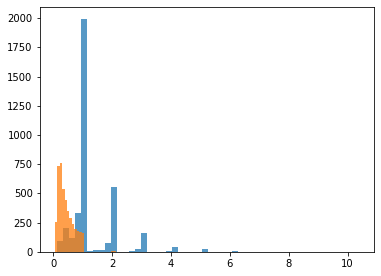

In [16]:
fig, ax = plt.subplots(figsize=(6,4.5))
_, _, dominant_patch = plt.hist(dominant_span_len_ratio, 50, alpha=0.75, label="Dominant")
_, _, reference_patch = plt.hist(reference_span_len_ratio, 50, alpha=0.75, label="Reference")
plt.show()

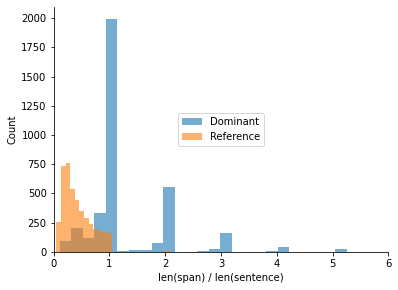

In [17]:
fig, ax = plt.subplots(figsize=(6,4.5))
_, _, dominant_patch = plt.hist(dominant_span_len_ratio, 50, alpha=0.6, label="Dominant")
_, _, reference_patch = plt.hist(reference_span_len_ratio, 50, alpha=0.6, label="Reference")
plt.xlim([0,6])
#plt.ylim([0,750])
#plt.vlines([dominant_span_ratio_mean],-50, 2000, color="black", linewidth=1, linestyles="dashed")
#plt.vlines([reference_span_ratio_mean],-50, 2000, color="black", linewidth=1, linestyles="dashed")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.legend(loc="center")
#plt.title("Histogram of the len of dominant & reference spans w/o citation marks")
plt.xlabel('len(span) / len(sentence)')
plt.ylabel('Count')
#plt.show()
plt.savefig("span_vs_sent_lens.pdf",dpi=600,bbox_inches='tight')

In [18]:
np.mean(np.array(dominant_span_len_ratio) < 1)

0.2752839372633856

In [19]:
np.mean(np.array(dominant_span_len_ratio) == 1)

0.46782044348296375

In [20]:
np.mean(np.array(dominant_span_len_ratio) > 1)

0.2568956192536506

In [21]:
dominant_span_lens, dominant_span_lens_no_citation_mark, reference_span_lens, reference_span_lens_no_citation_mark = span_length_by_citation(dataset)

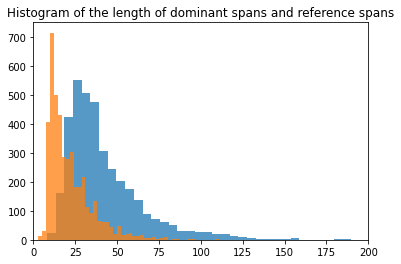

In [22]:
plt.figure()
plt.hist(dominant_span_lens, 50, alpha=0.75)
plt.hist(reference_span_lens, 50, alpha=0.75)
plt.title("Histogram of the length of dominant spans and reference spans")
plt.xlim([0,200])
plt.show()

In [23]:
line_metric = np.mean

In [24]:
dominant_span_lens_no_citation_mark_median = line_metric(dominant_span_lens_no_citation_mark)
reference_span_lens_no_citation_mark_median = line_metric(reference_span_lens_no_citation_mark)
print(dominant_span_lens_no_citation_mark_median, reference_span_lens_no_citation_mark_median)

34.34126554894537 8.293806124798527


In [25]:
len(dominant_span_lens_no_citation_mark), len(reference_span_lens_no_citation_mark)

(3698, 4343)

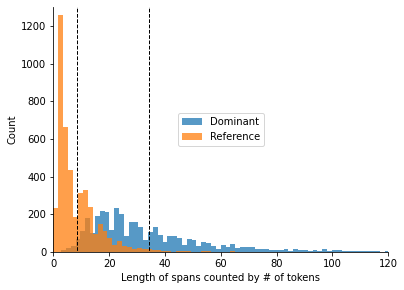

In [26]:
fig, ax = plt.subplots(figsize=(6,4.5))
_, _, dominant_patch = plt.hist(dominant_span_lens_no_citation_mark, 150, alpha=0.75, label="Dominant")
_, _, reference_patch = plt.hist(reference_span_lens_no_citation_mark, 50, alpha=0.75, label="Reference")
plt.xlim([0,120])
plt.ylim([0,1300])
plt.vlines([dominant_span_lens_no_citation_mark_median],-50, 2000, color="black", linewidth=1, linestyles="dashed")
plt.vlines([reference_span_lens_no_citation_mark_median],-50, 2000, color="black", linewidth=1, linestyles="dashed")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.legend(loc="center")
#plt.title("Histogram of the len of dominant & reference spans w/o citation marks")
plt.xlabel('Length of spans counted by # of tokens')
plt.ylabel('Count')
#plt.show()
plt.savefig("span_lens_no_citation_mark.pdf",dpi=600,bbox_inches='tight')

In [27]:
# Count of co-occurence of discourse and citation spans.
dominant_discourse = {k: 0 for k in discourse_label_types.keys()}
reference_discourse = {k: 0 for k in discourse_label_types.keys()}

for data in dataset:
    for span_idx, span in enumerate(data["span2sent_mapping"]):
        #for sent_idx in span:
        sent_idx = span[0] # A single span will always correspond to the same type of discourse tag.
        if data["span_citation_mapping"][span_idx]["span_type"] == "Dominant":
            dominant_discourse[data["discourse_labels"][sent_idx]] += 1
        else:
            reference_discourse[data["discourse_labels"][sent_idx]] += 1
# Should analyze around spans, not discourse!!!
#for data in dataset:
#    for discourse, counts in zip(data["discourse_labels"], data["citation_type_by_sentence"]):
#        dominant_discourse[discourse] += counts[0]
#        reference_discourse[discourse] += counts[1]

In [28]:
dominant_cooccurence = sum([v for k,v in dominant_discourse.items()])
reference_cooccurence = sum([v for k,v in reference_discourse.items()])
total_cooccurence = dominant_cooccurence + reference_cooccurence
pD = dominant_cooccurence / total_cooccurence
pR = reference_cooccurence / total_cooccurence

In [29]:
dominant_cooccurence, reference_cooccurence

(3698, 4343)

In [30]:
total_dominant = sum([v for v in dominant_discourse.values()])
dominant_discourse_fraction = {k: v/total_dominant for k,v in dominant_discourse.items()}
print("Distribution of discourse labels given a dominant citation")
print_percentage(dominant_discourse_fraction)

Distribution of discourse labels given a dominant citation
Single_summ 80.8%
Multi_summ 18.7%
Narrative_cite 0.4%
Reflection 0.1%
Transition 0.0%
Other 0.0%


In [31]:
print("Joint distribution of discourse labels and dominant citation")
print_percentage(dominant_discourse_fraction, pD)

Joint distribution of discourse labels and dominant citation
Single_summ 37.1%
Multi_summ 8.6%
Narrative_cite 0.2%
Reflection 0.0%
Transition 0.0%
Other 0.0%


In [32]:
total_reference = sum([v for v in reference_discourse.values()])
reference_discourse_fraction = {k: v/total_reference for k,v in reference_discourse.items()}
print("Distribution of discourse labels given a reference citation")
print_percentage(reference_discourse_fraction)

Distribution of discourse labels given a reference citation
Narrative_cite 90.3%
Reflection 6.0%
Multi_summ 2.5%
Single_summ 1.1%
Transition 0.1%
Other 0.0%


In [33]:
print("Joint distribution of discourse labels and reference citation")
print_percentage(reference_discourse_fraction, pR)

Joint distribution of discourse labels and reference citation
Narrative_cite 48.8%
Reflection 3.2%
Multi_summ 1.3%
Single_summ 0.6%
Transition 0.1%
Other 0.0%


In [34]:
dominant_given_discourse = {}
reference_given_discourse = {}
for k in discourse_label_types.keys():
    dominant = dominant_discourse[k]
    reference = reference_discourse[k]
    dominant_given_discourse[k] = dominant / (dominant + reference + 1e-8)
    reference_given_discourse[k] = reference / (dominant + reference + 1e-8)

In [35]:
print_percentage(reference_given_discourse)

Narrative_cite 99.6%
Reflection 98.9%
Transition 83.3%
Multi_summ 13.5%
Single_summ 1.6%
Other 0.0%


In [36]:
print_percentage(dominant_given_discourse)

Single_summ 98.4%
Multi_summ 86.5%
Transition 16.7%
Reflection 1.1%
Narrative_cite 0.4%
Other 0.0%


In [37]:
discourse_counts_by_paragraph = []
paragraph_ids = []
for data in dataset:
    paragraph_ids.append(data["paragraph_id"])
    counts = [0 for i in range(len(discourse_label_types))]
    for discourse in data["discourse_labels"]:
        counts[discourse_label_types[discourse]] += 1
    #counts[-1] = len(data["discourse_labels"])
    discourse_counts_by_paragraph.append(counts)
discourse_counts_by_paragraph = np.array(discourse_counts_by_paragraph)
#discourse_counts_by_paragraph = discourse_counts_by_paragraph[:,1:4]
discourse_fraction_by_paragraph = discourse_counts_by_paragraph / (np.sum(discourse_counts_by_paragraph,axis=1).reshape(-1,1)+1e-8)

In [38]:
discourse_counts_by_paragraph

array([[4, 0, 0, 0, 0, 0],
       [2, 2, 0, 0, 2, 0],
       [0, 2, 0, 0, 0, 0],
       ...,
       [1, 3, 2, 3, 2, 0],
       [1, 4, 0, 3, 2, 0],
       [0, 1, 0, 0, 1, 0]])

In [39]:
discourse_label_types = {
    "Transition":0,
    "Single_summ": 1,
    "Multi_summ": 2,
    "Narrative_cite":3,
    "Reflection":4,
    "Other":5
    }

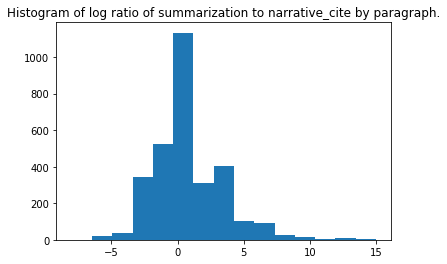

In [40]:
eps = 1e-2
summ_count = np.sum(discourse_counts_by_paragraph[:,1:3],axis=1)
narrative_count = discourse_counts_by_paragraph[:,3]
ratio = summ_count - narrative_count
plt.figure()
plt.hist(ratio,15)
plt.title("Histogram of log ratio of summarization to narrative_cite by paragraph.")
plt.show()

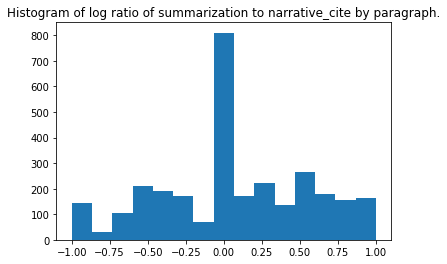

In [41]:
total = np.sum(discourse_counts_by_paragraph,axis=1)+1e-8
summ_count = np.sum(discourse_counts_by_paragraph[:,1:3],axis=1)
narrative_count = discourse_counts_by_paragraph[:,3]
ratio = (summ_count - narrative_count) / total
plt.figure()
plt.hist(ratio,15)
plt.title("Histogram of log ratio of summarization to narrative_cite by paragraph.")
plt.show()

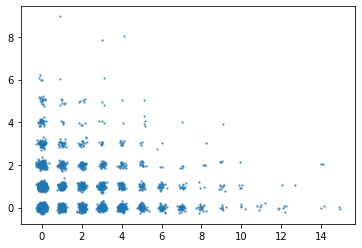

In [42]:
plt.figure()
sigma = 0.1
jitter_x = np.random.normal(0, sigma, summ_count.size)
jitter_y = np.random.normal(0, sigma, narrative_count.size)
plt.scatter(summ_count+jitter_x, narrative_count + jitter_y, s=2, alpha=0.6)
plt.show()

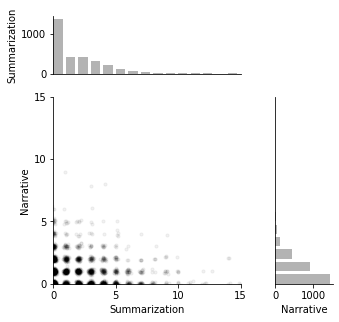

In [43]:

x_jitter = (summ_count+jitter_x)
y_jitter = (narrative_count + jitter_y)
x = summ_count
y = narrative_count
x_median = np.median(x)
y_median = np.median(y)

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left + width + 0.08
left_h = left + width + 0.12

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

fig = plt.figure(1,figsize=(4,4))
axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

axScatter.scatter(x_jitter, y_jitter, s=10, color='k', alpha=0.05)

binwidth = 1
width = binwidth * 0.75
lim_min = 0
lim_max = 15
axScatter.set_xlim((lim_min, lim_max))
axScatter.set_ylim((lim_min, lim_max))

bins = np.arange(lim_min, lim_max + binwidth, binwidth)
xCount,_,_ = axHistx.hist(x, width = width, bins=bins, color = 'w')
yCount,_,_ = axHisty.hist(y, height = width, bins=bins, orientation='horizontal', color = 'w')

gray = [0.7,0.7,0.7]
#axHistx.hist(x, width=width, bins=bins, weights=np.zeros_like(x) + 1. / x.size, color = gray)
#axHisty.hist(y, height = width, bins=bins, weights=np.zeros_like(y) + 1. / y.size, orientation='horizontal', color = gray)

axHistx.hist(x, width=width, bins=bins, color = gray)
axHisty.hist(y, height = width, bins=bins, orientation='horizontal', color = gray)

lim_min_hist = 0
lim_max_hist = 15

axHistx.set_xlim([lim_min_hist,lim_max_hist])
axHisty.set_ylim([lim_min_hist,lim_max_hist])

xCountMax = np.max(xCount)
yCountMax = np.max(yCount)

#axHistx.plot([x_median,x_median],[0,xCountMax],'k--')
#axHisty.plot([0,yCountMax],[y_median,y_median],'k--')

#axHistx.yaxis.set_ticks(np.arange(0, xCountMax, step=0.1))
#axHisty.xaxis.set_ticks(np.arange(0, yCountMax, step=0.1))
axHistx.locator_params(axis = 'y', nbins = 2)
axHisty.locator_params(axis = 'x', nbins = 2)
axHistx.xaxis.set_ticks([])
axHisty.yaxis.set_ticks([])
axScatter.locator_params(axis = 'x', nbins = 4)
axScatter.locator_params(axis = 'y', nbins = 4)


axHistx.spines['top'].set_visible(False)
axHistx.spines['right'].set_visible(False)
axHistx.xaxis.set_ticks_position('bottom')
axHistx.yaxis.set_ticks_position('left')

axHisty.spines['top'].set_visible(False)
axHisty.spines['right'].set_visible(False)
axHisty.xaxis.set_ticks_position('bottom')
axHisty.yaxis.set_ticks_position('left')

axScatter.spines['top'].set_visible(False)
axScatter.spines['right'].set_visible(False)
axScatter.xaxis.set_ticks_position('bottom')
axScatter.yaxis.set_ticks_position('left')

axScatter.set_xlabel('Summarization')
axScatter.set_ylabel('Narrative')
axHistx.set_ylabel('Summarization')
axHisty.set_xlabel('Narrative')

#fig.savefig(filename,dpi=600,bbox_inches='tight')
plt.show()

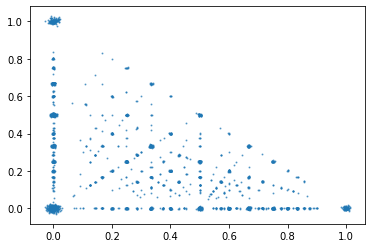

In [44]:
plt.figure()
total = np.sum(discourse_counts_by_paragraph,axis=1)+1e-8
sigma = 0.01
jitter_x = np.random.normal(0, sigma, summ_count.size)
jitter_y = np.random.normal(0, sigma, narrative_count.size)
plt.scatter((summ_count+jitter_x)/total, (narrative_count + jitter_y)/total, s=1, alpha=0.6)
plt.show()

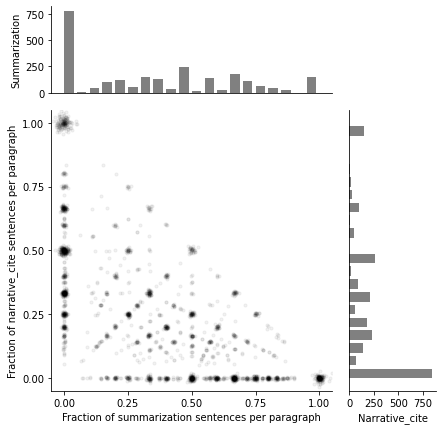

In [45]:
summ_count = np.sum(discourse_counts_by_paragraph[:,1:3],axis=1)
narrative_count = discourse_counts_by_paragraph[:,3]

valid = np.logical_or(summ_count!=0, narrative_count!=0)
#valid = summ_count >= 0

valid_summ_count = summ_count[valid]
valid_narrative_count = narrative_count[valid]

valid_total = np.sum(discourse_counts_by_paragraph[valid],axis=1)+1e-8
sigma = 0.02
jitter_x = np.random.normal(0, sigma, valid_summ_count.size)
jitter_y = np.random.normal(0, sigma, valid_narrative_count.size)

x_jitter = (valid_summ_count+jitter_x)/valid_total
y_jitter = (valid_narrative_count + jitter_y)/valid_total
x = (valid_summ_count)/valid_total
y = (valid_narrative_count)/valid_total
x_median = np.median(x)
y_median = np.median(y)

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left + width + 0.04
left_h = left + width + 0.04

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

fig = plt.figure(1,figsize=(6,6))
axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

axScatter.scatter(x_jitter, y_jitter, s=10, color='k', alpha=0.05)

binwidth = 0.05
width = binwidth * 0.75
lim_min = -0.05
lim_max = 1.05
axScatter.set_xlim((lim_min, lim_max))
axScatter.set_ylim((lim_min, lim_max))

bins = np.arange(lim_min, lim_max + binwidth, binwidth)

gray = [0.5,0.5,0.5]

axHistx.hist(x, width=width, bins=bins, color = gray)
axHisty.hist(y, height = width, bins=bins, orientation='horizontal', color = gray)

lim_min_hist = -0.05
lim_max_hist = 1.05

axHistx.set_xlim([lim_min_hist,lim_max_hist])
axHisty.set_ylim([lim_min_hist,lim_max_hist])

xCountMax = np.max(xCount)
yCountMax = np.max(yCount)

axHistx.locator_params(axis = 'y', nbins = 4)
axHisty.locator_params(axis = 'x', nbins = 4)
axHistx.xaxis.set_ticks([])
axHisty.yaxis.set_ticks([])
axScatter.locator_params(axis = 'x', nbins = 5)
axScatter.locator_params(axis = 'y', nbins = 5)


axHistx.spines['top'].set_visible(False)
axHistx.spines['right'].set_visible(False)
axHistx.xaxis.set_ticks_position('bottom')
axHistx.yaxis.set_ticks_position('left')

axHisty.spines['top'].set_visible(False)
axHisty.spines['right'].set_visible(False)
axHisty.xaxis.set_ticks_position('bottom')
axHisty.yaxis.set_ticks_position('left')

axScatter.spines['top'].set_visible(False)
axScatter.spines['right'].set_visible(False)
axScatter.xaxis.set_ticks_position('bottom')
axScatter.yaxis.set_ticks_position('left')

axScatter.set_xlabel('Fraction of summarization sentences per paragraph')
axScatter.set_ylabel('Fraction of narrative_cite sentences per paragraph')
axHistx.set_ylabel('Summarization')
axHisty.set_xlabel('Narrative_cite')

#fig.savefig("Summ_Narrative_scatter.pdf",dpi=600,bbox_inches='tight')
plt.show()

In [46]:
len(valid_summ_count)

2434

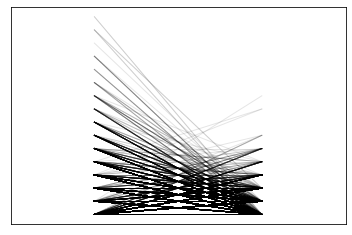

In [47]:
plt.figure()
for s,n in zip(summ_count, narrative_count):
    plt.plot([0,1],[s,n], color="k", linewidth=1, alpha=0.1)
plt.xticks([])
plt.yticks([])
plt.xlim([-0.5,1.5])
plt.show()

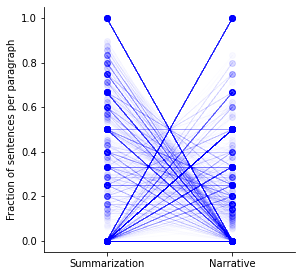

In [48]:
sigma = 0
jitter_x = np.random.normal(0, sigma, summ_count.size)
jitter_y = np.random.normal(0, sigma, narrative_count.size)
total = np.sum(discourse_counts_by_paragraph,axis=1)+1e-8
fig,ax = plt.subplots(figsize=(4.5,4.5))
for s,n,t in zip(summ_count+jitter_x, narrative_count+jitter_y, total):
    plt.plot([0,1],[s/t,n/t], marker='o', color="b", linewidth=1, alpha=0.01)
ax.set_xticks([0,1])
ax.set_xticklabels(["Summarization","Narrative"])
plt.xlim([-0.5,1.5])
plt.ylabel("Fraction of sentences per paragraph")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.show()
#fig.savefig("Summ_Narrative_parallel.pdf",dpi=600,bbox_inches='tight')

In [49]:
summ_count = np.sum(discourse_counts_by_paragraph[:,1:3],axis=1)
narrative_count = discourse_counts_by_paragraph[:,3]

valid = np.logical_or(summ_count!=0, narrative_count!=0)
#valid = summ_count >= 0

valid_summ_count = summ_count[valid]
valid_narrative_count = narrative_count[valid]

valid_total = np.sum(discourse_counts_by_paragraph[valid],axis=1)+1e-8
sigma = 0
jitter_x = np.random.normal(0, sigma, valid_summ_count.size)
jitter_y = np.random.normal(0, sigma, valid_narrative_count.size)

x_jitter = (valid_summ_count+jitter_x)/valid_total
y_jitter = (valid_narrative_count + jitter_y)/valid_total
x = (valid_summ_count)/valid_total
y = (valid_narrative_count)/valid_total
x_median = np.median(x)
y_median = np.median(y)

In [55]:
summarization_proportion = x_jitter
narrative_proportion = y_jitter

In [57]:
summarization_only = np.mean(narrative_proportion == 0)
narrative_only = np.mean(summarization_proportion == 0)
mixture = np.mean(np.logical_and(summarization_proportion > 0, narrative_proportion > 0))

In [58]:
summarization_only, narrative_only, mixture

(0.3463434675431389, 0.3208709942481512, 0.33278553820870993)

In [50]:
valid_total.shape

(2434,)

In [56]:
summ_count.shape

(3031,)

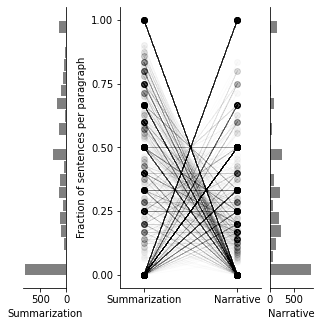

In [51]:
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left + width + 0.04
left_h = left + width + 0.04

rect_scatter = [left, bottom, width, height]
rect_histx = [left - 0.45, bottom, 0.2, height]
rect_histy = [left_h, bottom, 0.2, height]

fig = plt.figure(1,figsize=(3,6))
axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

for s,n,t in zip(x_jitter, y_jitter, valid_total):
    axScatter.plot([0,1],[s,n], marker='o', color="k", linewidth=1, alpha=0.01)
#axScatter.scatter(x_jitter, y_jitter, s=10, color='k', alpha=0.05)

binwidth = 0.05
width = binwidth * 0.9
axScatter.set_xlim((-0.25, 1.25))
axScatter.set_ylim((-0.05, 1.05))

bins = np.arange(lim_min, lim_max + binwidth, binwidth)

gray = [0.5,0.5,0.5]

axHistx.hist(x_jitter, height = width, bins=bins, orientation='horizontal', color = gray)
axHisty.hist(y_jitter, height = width, bins=bins, orientation='horizontal', color = gray)

lim_min_hist = -0.05
lim_max_hist = 1.05

axHistx.set_ylim([lim_min_hist,lim_max_hist])
axHisty.set_ylim([lim_min_hist,lim_max_hist])

#axHistx.locator_params(axis = 'x', nbins = 4)
#axHisty.locator_params(axis = 'x', nbins = 4)
axHistx.yaxis.set_ticks([])
axHisty.yaxis.set_ticks([])
#axScatter.locator_params(axis = 'x', nbins = 2)
axScatter.locator_params(axis = 'y', nbins = 5)
axScatter.set_xticks([0,1])
axScatter.set_xticklabels(["Summarization","Narrative"])

axHistx.spines['top'].set_visible(False)
axHistx.spines['left'].set_visible(False)
axHistx.xaxis.set_ticks_position('bottom')
axHistx.yaxis.set_ticks_position('left')
axHistx.invert_xaxis()

axHisty.spines['top'].set_visible(False)
axHisty.spines['right'].set_visible(False)
axHisty.xaxis.set_ticks_position('bottom')
axHisty.yaxis.set_ticks_position('left')

axScatter.spines['top'].set_visible(False)
axScatter.spines['right'].set_visible(False)
axScatter.xaxis.set_ticks_position('bottom')
axScatter.yaxis.set_ticks_position('left')

#axScatter.set_xlabel()
axScatter.set_ylabel("Fraction of sentences per paragraph")
axHistx.set_xlabel('Summarization')
axHisty.set_xlabel('Narrative')

fig.savefig("Summ_Narrative_parallel_histogram.pdf",dpi=600,bbox_inches='tight')
#plt.show()

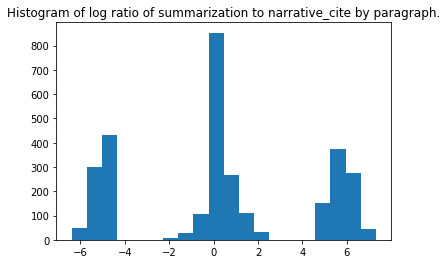

In [52]:
eps = 1e-2
ratio = np.log((np.sum(discourse_counts_by_paragraph[:,1:3],axis=1)+ eps) / (discourse_counts_by_paragraph[:,3] + eps))
plt.figure()
plt.hist(ratio,20)
plt.title("Histogram of log ratio of summarization to narrative_cite by paragraph.")
plt.show()

In [ ]:
paragraphs_with_citation = np.sum(discourse_counts_by_paragraph[:,1:4],axis=1) > 0
discourse_counts_with_citation = discourse_counts_by_paragraph[paragraphs_with_citation,:]

In [ ]:
discourse_counts_with_citation.shape

In [ ]:
eps = 1e-2
ratio = np.log((np.sum(discourse_counts_with_citation[:,1:3],axis=1)+ eps) / (discourse_counts_with_citation[:,3] + eps))
plt.figure()
plt.hist(ratio,20)
plt.title("Histogram of log ratio of summarization to narrative_cite by paragraph.")
plt.show()

In [ ]:
discourse_counts_by_paper = {}
for data in dataset:
    paragraph_id = data["paragraph_id"]
    paper_id = paragraph_id.split("_")[0]
    if paper_id in discourse_counts_by_paper:
        counts = discourse_counts_by_paper[paper_id]
    else:
        counts = [0 for i in range(len(discourse_label_types))]
    for discourse in data["discourse_labels"]:
        counts[discourse_label_types[discourse]] += 1
    discourse_counts_by_paper[paper_id] = counts
discourse_counts_by_paper = np.array([paper for ID, paper in discourse_counts_by_paper.items()])
discourse_fraction_by_paper = discourse_counts_by_paper / np.sum(discourse_counts_by_paper,axis=1).reshape(-1,1)

In [ ]:
eps = 1e-2
ratio = np.log((np.sum(discourse_counts_by_paper[:,1:3],axis=1)+ eps) / (discourse_counts_by_paper[:,3] + eps))
plt.figure()
plt.hist(ratio,25)
plt.title("Histogram of log ratio of summarization to narrative_cite by paper.")
plt.show()

In [ ]:
papers_with_citation = np.sum(discourse_counts_by_paper[:,1:4],axis=1) > 0
discourse_counts_with_citation = discourse_counts_by_paper[papers_with_citation,:]

In [ ]:
eps = 1e-2
ratio = np.log((np.sum(discourse_counts_with_citation[:,1:3],axis=1)+ eps) / (discourse_counts_with_citation[:,3] + eps))
plt.figure()
plt.hist(ratio,25)
plt.title("Histogram of log ratio of summarization to narrative_cite by paper.")
plt.show()